This is a tutorial in data cleanup using `pandas`. In one of my trainings, I asked the following questions. 


* Download the swimming data from https://en.wikipedia.org/wiki/List_of_world_records_in_swimming
* Combine the frames with the records and clean up the data
* Give a ranking of the swimming speed over different disciplines
* Save the clean data in a file called `swimming_records.feather`
* Give an estimate of how much time a turning point adds to swimming a distance
* Give an estimate of how much time a start adds to adds to swimming 

In this post, I try and answer these. 

---

In [1]:
import pandas as pd

%pylab inline

Populating the interactive namespace from numpy and matplotlib


### 1. Getting the data

These swimming records are in HTML tables, and luckily the `pd.read_html` function does work. 

In [2]:
url = "https://en.wikipedia.org/wiki/List_of_world_records_in_swimming"

tables = pd.read_html(url, header = 0, encoding='utf-8')
tables[0].head(5)

,Event,Time,Unnamed: 2,Name,Nationality,Date,Meet,Location,Ref
0,01 ! 50 m freestyle,20.91,NaN,"Cielo, CésarCésar Cielo",Brazil,18 December 2009,Brazilian Championships,"Brazil, São Paulo ! São Paulo, Brazil",[9][10]
1,02 ! 100 m freestyle,46.91,NaN,"Cielo, CésarCésar Cielo",Brazil,30 July 2009,World Championships,"Italy, Rome ! Rome, Italy",[11][12]
2,03 ! 200 m freestyle,1:42.00,NaN,"Biedermann, PaulPaul Biedermann",Germany,28 July 2009,World Championships,"Italy, Rome ! Rome, Italy",[13][14]
3,04 ! 400 m freestyle,3:40.07,NaN,"Biedermann, PaulPaul Biedermann",Germany,26 July 2009,World Championships,"Italy, Rome ! Rome, Italy",[15][16]
4,05 ! 800 m freestyle,7:32.12,NaN,Zhang Lin,China,29 July 2009,World Championships,"Italy, Rome ! Rome, Italy",[17][18]


There are a few extra tables that we don't need. In addition, the tables refer to long course (50m bath) or short course. I use a `zip` to append that information and then combine all the records into a separate table. 

In [3]:
category = "men", "women", "mixed", "men", "women", "mixed"
course = "long", "long", "long", "short", "short", "short"

record_tables = [t for t in tables if "Event" in t.columns]
len(record_tables)

6

In [4]:
ts = [t.assign(category = c, course = i) for t, c, i in zip(record_tables, category, course)]
raw = pd.concat(ts).reset_index(drop=True)
raw.sample(5)

,Event,Time,Unnamed: 2,Name,Nationality,Date,Meet,Location,Ref,category,course
15,16 ! 200 m individual medley,1:54.00,NaN,"Lochte, RyanRyan Lochte",United States,28 July 2011,World Championships,"China, Shanghai ! Shanghai, China",[34][35],men,long
2,03 ! 200 m freestyle,1:42.00,NaN,"Biedermann, PaulPaul Biedermann",Germany,28 July 2009,World Championships,"Italy, Rome ! Rome, Italy",[13][14],men,long
49,08 ! 100 m backstroke,48.90,NaN,"Kolesnikov, KlimentKliment Kolesnikov",Russia,22 December 2017,Vladimir Salnikov Cup,"Russia, Saint Petersburg ! Saint Petersburg, R...",[79],men,short
73,08 ! 100 m backstroke,55.03,NaN,"Hosszú, KatinkaKatinka Hosszú",Hungary,4 December 2014,World Championships,"Qatar, Doha ! Doha, Qatar",[100],women,short
56,15 ! 200 m butterfly,1:48.56,NaN,"le Clos, ChadChad le Clos",South Africa,5 November 2013,World Cup,"Singapore, Singapore ! Singapore, Singapore",[83],men,short


First things first, I like to work with column names without spaces. There are two columns that are not useful to us, so I drop them immediately. 

In [5]:
raw.shape

(95, 11)

In [6]:
raw.rename(columns = lambda x: x.lower().replace(' ', ''), inplace = True)
raw.drop(['ref', 'unnamed:2'], axis = 1, inplace = True, errors='ignore')
raw.head(2)

,event,time,name,nationality,date,meet,location,category,course
0,01 ! 50 m freestyle,20.91,"Cielo, CésarCésar Cielo",Brazil,18 December 2009,Brazilian Championships,"Brazil, São Paulo ! São Paulo, Brazil",men,long
1,02 ! 100 m freestyle,46.91,"Cielo, CésarCésar Cielo",Brazil,30 July 2009,World Championships,"Italy, Rome ! Rome, Italy",men,long


---

### 2. Parsing the data in the event and time columns 

The data has a lot of challenging parsing problems. In this post, I use regexes to solve most of those. There are non-breaking spaces, as you cannot see in the table, but it does show if you print separate values as below. There is also a weird `x` character, that you might mistake for an 'x'. I just copied it into the regex formula. 

In [7]:
raw.event.values[0], raw.event.values[25], raw.event.values[17]

('01 ! 50\xa0m freestyle',
 '06 ! 1500\xa0m freestyle',
 '18 ! 4×100\xa0m freestyle relay')

In [8]:
parsed_events = raw.event.str.replace(u'\xa0', ' ').str.extract('[\d\.]+ ! (?:(?P<team_size>4)×)?(?P<distance>\d{2,4}) m (?P<swimstyle>[a-z ]+)', expand = True)
parsed_events[parsed_events.swimstyle.isnull()]

,team_size,distance,swimstyle


In [9]:
parsed_events["team_size"] = parsed_events.team_size.fillna(1).astype(int)
parsed_events.distance = parsed_events.distance.astype(int) * parsed_events.team_size

parsed_events.assign(original = raw.event).sample(5)

,team_size,distance,swimstyle,original
32,1,50,butterfly,13 ! 50 m butterfly
60,4,200,freestyle relay,19.1 ! 4×50 m freestyle relay
73,1,100,backstroke,08 ! 100 m backstroke
23,1,400,freestyle,04 ! 400 m freestyle
14,1,200,butterfly,15 ! 200 m butterfly


Next up are the times. It is possible to tackle these with `strftime`, but since I'm doing regexes already, let's use those again. 

In [10]:
parsed_times = raw.time.str.extract("(?P<m>\d{1,2})?:?(?P<s>\d{2})\.(?P<ms>\d{2})", expand = True)
time_seconds = parsed_times.m.astype(float).fillna(0) * 60 + parsed_times.s.astype(float) + parsed_times.ms.astype(float) / 100
raw.assign(time_seconds = time_seconds)[["event", "time_seconds"]].sample(10)

,event,time_seconds
64,22 ! 4×50 m medley relay,90.44
92,23 ! 4×100 m medley relay,225.20
34,15 ! 200 m butterfly,121.81
43,02 ! 100 m freestyle,44.94
89,21 ! 4×200 m freestyle relay,452.85
25,06 ! 1500 m freestyle,925.48
20,01 ! 50 m freestyle,23.67
18,19 ! 4×200 m freestyle relay,418.55
50,09 ! 200 m backstroke,105.63
72,07 ! 50 m backstroke,25.67


---

### 3. Splitting doubled name and location

The record holder names come out of the `html` in an interesting way. The `pd.read_html` function includes the title of the cell, which is the same name, in different order. Instead of splitting the strings on half their length plus one, I use a very explicit backref operator to make sure my assumptions on these data fields are correct. 

In [11]:
raw.name.values[0], raw.name.values[10]

('Cielo, CésarCésar Cielo', 'Peaty, AdamAdam Peaty')

In [12]:
## Two patterns. One works for most
## But names like Sun Yang are not repeated
## Maybe because it's a chinese character in the html that is ommitted by the parser?
parsed_names = raw.name.str.extract(r"(?P<last_name>[\w ]+), (?P<first_name>[\S ]+)\2 \1", expand = True)
parsed_names_simple = raw.name.str.extract(r"^(?P<last_name>[\w]+) (?P<first_name>[\w ]+)$", expand = True)

q = parsed_names.first_name.isnull() & parsed_names_simple.first_name.notnull()
parsed_names.loc[q] = parsed_names_simple.loc[q]

parsed_names.assign(original = raw.name).sample(10)

,last_name,first_name,original
26,Zhao,Jing,Zhao Jing
45,Agnel,Yannick,"Agnel, YannickYannick Agnel"
36,Hosszú,Katinka,"Hosszú, KatinkaKatinka Hosszú"
0,Cielo,César,"Cielo, CésarCésar Cielo"
69,Belmonte García,Mireia,"Belmonte García, MireiaMireia Belmonte García"
5,Sun,Yang,Sun Yang
80,Alshammar,Therese,"Alshammar, ThereseTherese Alshammar"
50,Larkin,Mitch,"Larkin, MitchMitch Larkin"
3,Biedermann,Paul,"Biedermann, PaulPaul Biedermann"
74,Hosszú,Katinka,"Hosszú, KatinkaKatinka Hosszú"


These names look correct. For the teams, the medley records, I leave the names blank. Next up are the location fields. 

In [13]:
raw.location.values[0], raw.location.values[17]

('Brazil, São Paulo ! São Paulo, Brazil', 'China, Beijing ! Beijing, China')

In [14]:
parsed_locations = raw.location.str.extract(r'(?P<country>[\w ]+), (?P<city>[\w ]+) ! \2, \1', expand = True)
parsed_locations.assign(original = raw.location).sample(5)

,country,city,original
66,Germany,Berlin,"Germany, Berlin ! Berlin, Germany"
42,Qatar,Doha,"Qatar, Doha ! Doha, Qatar"
74,Qatar,Doha,"Qatar, Doha ! Doha, Qatar"
48,Qatar,Doha,"Qatar, Doha ! Doha, Qatar"
37,Brazil,Rio de Janeiro,"Brazil, Rio de Janeiro ! Rio de Janeiro, Brazil"


In [15]:
## check whether the parsing succeeded for all the locations
parsed_locations[parsed_locations.country.isnull()]

,country,city


---

### 4. Combining the data into a clean set

We have all the separate parts of the dataset and assemble them into a `pd.DataFrame` called `events. 

In [16]:
events = parsed_events.join(
    time_seconds.rename("time")
).join(
    pd.to_datetime(raw.date)
).join(parsed_locations).join(parsed_names).join(
    raw[["course", "category", "nationality", "meet"]]
)

events.sample(5)

,team_size,distance,swimstyle,time,date,country,city,last_name,first_name,course,category,nationality,meet
86,4,200,freestyle relay,93.91,2017-12-15,Denmark,Copenhagen,NaN,NaN,short,women,Netherlands,European Championships
5,1,1500,freestyle,871.02,2012-08-04,United Kingdom,London,Sun,Yang,long,men,China,Olympic Games
57,1,100,individual medley,50.30,2016-08-30,Germany,Berlin,Morozov,Vladimir,short,men,Russia,World Cup
29,1,50,breaststroke,29.40,2017-07-30,Hungary,Budapest,King,Lilly,long,women,United States,World Championships
43,1,100,freestyle,44.94,2008-12-13,Croatia,Rijeka,Leveaux,Amaury,short,men,France,European Championships


In [17]:
events.dtypes

team_size               int64
distance                int64
swimstyle              object
time                  float64
date           datetime64[ns]
country                object
city                   object
last_name              object
first_name             object
course                 object
category               object
nationality            object
meet                   object
dtype: object

This looks fine. I'd like to use the `categorical` type in `pandas`, but it actually gives me some problems here, see https://github.com/pandas-dev/pandas/issues/19136 for example. Let's make some plots and the ranking of swimming speeds to check if this data looks allright. 

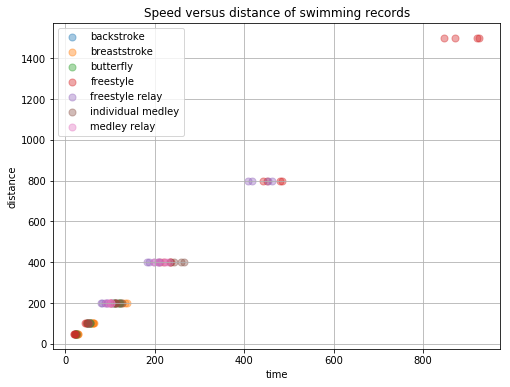

In [18]:
import seaborn as sns

fig = plt.figure(figsize = (8, 6))
ax = fig.subplots(1)
pal = sns.color_palette()

for i, (st, frame) in enumerate(events.groupby(["swimstyle"])):
    frame.plot.scatter(x = 'time', y = 'distance', label = st, ax = ax, color = pal[i], s = 50, alpha = .4);
    
plt.title("Speed versus distance of swimming records")
plt.grid(True);

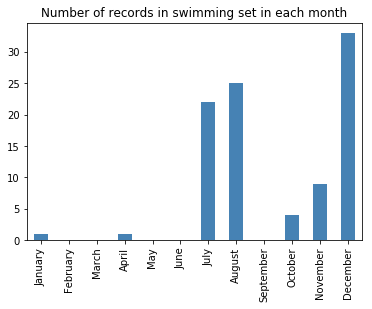

In [19]:
import calendar
month_names = [calendar.month_name[i] for i in range(1, 13)]

events.date.dt.strftime("%B").value_counts().reindex(month_names).plot.bar(color = "steelblue")
plt.title("Number of records in swimming set in each month");

Interesting that most records are broken in December. My first hypothesis would be that this has to do with a recent tournament.

---

### 5. Ranking the disciplines on speed

In [20]:
events["speed"] = events.distance / events.time
events.sort_values('speed', ascending = False).head()

,team_size,distance,swimstyle,time,date,country,city,last_name,first_name,course,category,nationality,meet,speed
61,4,200,freestyle relay,80.77,2008-12-14,Croatia,Rijeka,NaN,NaN,short,men,France,European Championships,2.476167
42,1,50,freestyle,20.26,2014-12-05,Qatar,Doha,Manaudou,Florent,short,men,France,World Championships,2.467917
60,4,200,freestyle relay,82.60,2014-12-06,Qatar,Doha,NaN,NaN,short,men,Russia,World Championships,2.421308
0,1,50,freestyle,20.91,2009-12-18,Brazil,São Paulo,Cielo,César,long,men,Brazil,Brazilian Championships,2.391200
54,1,50,butterfly,21.80,2009-11-14,Germany,Berlin,Deibler,Steffen,short,men,Germany,World Cup,2.293578


In [21]:
events.sort_values('speed', ascending = False).tail()

,team_size,distance,swimstyle,time,date,country,city,last_name,first_name,course,category,nationality,meet,speed
30,1,100,breaststroke,64.13,2017-07-25,Hungary,Budapest,King,Lilly,long,women,United States,World Championships,1.559333
85,1,400,individual medley,258.94,2017-08-12,Netherlands,Eindhoven,Belmonte Garcia,Mireia,short,women,Spain,World Cup,1.544759
36,1,400,individual medley,266.36,2016-08-06,Brazil,Rio de Janeiro,Hosszú,Katinka,long,women,Hungary,Olympic Games,1.501727
79,1,200,breaststroke,134.57,2009-12-18,United Kingdom,Manchester,Soni,Rebecca,short,women,United States,Duel in the Pool,1.486215
31,1,200,breaststroke,139.11,2013-08-01,Spain,Barcelona,Pedersen,Rikke Møller,long,women,Denmark,World Championships,1.437711


The fastest discipline is the 4 times 50 freestyle relay. That's interesting because that would mean that the split times on this have to be faster than the world record, at least for one. Another aspect to keep in mind is that some records are listed twice, I assume because of the records that were broken with the floating suits that came up some time ago, and were banned afterwards.  

The slowest discipline is the breaststroke, that makes sense. Apparently, there is no breaststroke 400m record. Also, from the table below, we can see quite clearly that short course is faster than long course. 

In [22]:
events.loc[events.swimstyle == "breaststroke", ["distance", "swimstyle", "speed", "time", "category", "course"]].sort_values('speed')

,distance,swimstyle,speed,time,category,course
31,200,breaststroke,1.437711,139.11,women,long
79,200,breaststroke,1.486215,134.57,women,short
30,100,breaststroke,1.559333,64.13,women,long
11,200,breaststroke,1.578906,126.67,men,long
76,100,breaststroke,1.603592,62.36,women,short
77,100,breaststroke,1.603592,62.36,women,short
78,100,breaststroke,1.603592,62.36,women,short
53,200,breaststroke,1.660578,120.44,men,short
29,50,breaststroke,1.700680,29.40,women,long
75,50,breaststroke,1.745810,28.64,women,short


In [23]:
events.to_feather("./data/swimming-records.feather")

Now that we have the data in what looks like a clean format, it is time to turn to the two other questions. 

---

### 6.  Give an estimate of how much time a turning point adds to swimming a distance

For calculating the extra time a turn adds, I use a pivot table. The idea is that I can only really compare the same distances and swimming styles. 

In [24]:
view = events.pivot_table(index=["distance", "swimstyle", "category"], columns='course', values='time').reset_index()
view.sample(5)

course,distance,swimstyle,category,long,short
46,800,freestyle relay,men,418.55,409.04
37,400,freestyle relay,mixed,199.60,NaN
13,100,butterfly,women,55.48,54.61
32,200,medley relay,mixed,NaN,97.17
48,1500,freestyle,men,871.02,848.06


In [25]:
view["additional_turnpoints"] = ((view.distance / 25) - 1) - ((view.distance / 50) - 1)
view["additional_time_per_turn"] = (view.short - view.long) / (view.additional_turnpoints)

view = view[~view.swimstyle.str.contains('relay')].copy()
view.sample(5)

course,distance,swimstyle,category,long,short,additional_turnpoints,additional_time_per_turn
23,200,butterfly,women,121.81,119.61,4.0,-0.5500
10,100,breaststroke,men,57.13,55.61,2.0,-0.7600
40,400,individual medley,women,266.36,258.94,8.0,-0.9275
18,200,backstroke,men,111.92,105.63,4.0,-1.5725
34,400,freestyle,men,220.07,212.25,8.0,-0.9775


Instead of averaging this, I will create a visualization that shows the differences in each discipline. 

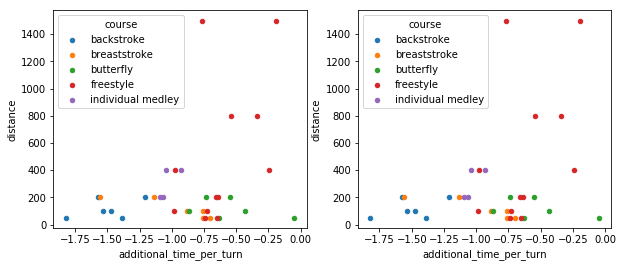

In [26]:
pal = sns.color_palette()

def plot_cat(category, ax):
    for i, (style, frame) in enumerate(view.groupby("swimstyle")):
        frame.plot.scatter(x = "additional_time_per_turn", y = "distance", ax = ax, label = style, c = pal[i]);
    
fig, axes = plt.subplots(1, 2, figsize = (10, 4))

for cat, ax in zip(["women", "men"], axes):
    plot_cat(cat, ax)

It's just a bit painful to fix this in `pandas` / `matplotlib`. I like to use `ggplot` for this, switch to `R`, but for this post I'll give `plotnine` a try.

/home/gijsx/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


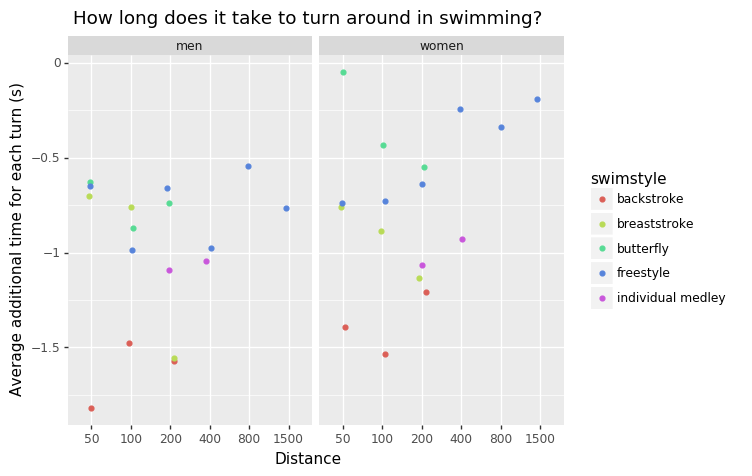

In [27]:
import plotnine as pn

fig = pn.ggplot(view[view.category != "mixed"].dropna()) + \
    pn.geom_jitter(
        pn.aes(x = "factor(distance)", y = "additional_time_per_turn", color = "swimstyle"), 
        width = .1, height = 0) + \
    pn.facet_wrap(facets = "category") + \
    pn.labs(
        x = "Distance", 
        y = "Average additional time for each turn (s)",
        title = "How long does it take to turn around in swimming?")
    
fig.draw();

`plotnine` works fine. I don't like the distance on the x axis. Below I've created one with speed, which is also not ideal. But we can see how long a turn takes. 

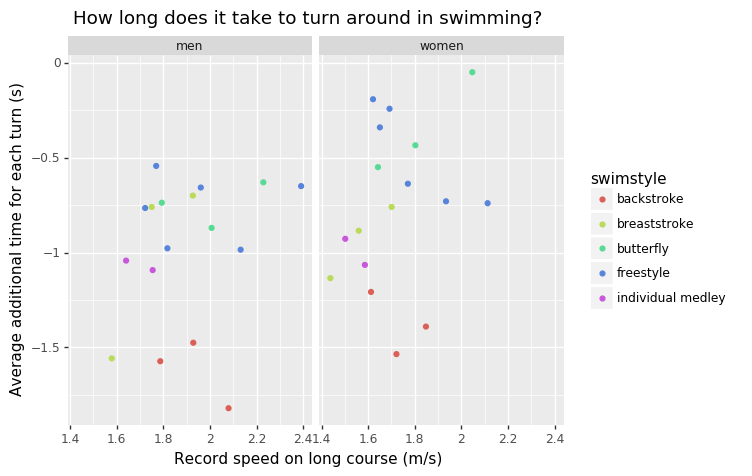

In [28]:
fig = pn.ggplot(view[view.category != "mixed"].dropna().assign(long_speed = view.distance / view.long)) + \
    pn.geom_point(pn.aes(x = "long_speed", y = "additional_time_per_turn", color = "swimstyle")) + \
    pn.facet_wrap(facets = "category") + \
    pn.labs(
        x = "Record speed on long course (m/s)", 
        y = "Average additional time for each turn (s)",
        title = "How long does it take to turn around in swimming?")
    
fig.draw();

We can see that a turn doesn't really take time, it's actually quicker than swimming. The difference between long and short course seems larger for backstroke. The turn in the butterfly style isn't too quick, perhaps because it's a tricky technique, or because the butterfly is already quite quick? On longer distances, the advantage of the turns disappears a bit. 

I'll consider this question answered, allthough there is much more to be said. The most important critique that I can come up with here is that it's perhaps not the best idea to answer this question using records. These are weird cases, and with more data, old records or just data from many swimming tournaments, we could produce a much more reliable estimate. 

### 7. Give an estimate of how much time a start adds to adds to swimming 

Now onto the next question; how long does a start take? This is tricky because we cannot really isolate the starts from the data, since each record has exactly one start. You could say 100m equals 2 x 50m without the extra start, but the swimming speeds are also different. I think I'd need some physical model to estimate speed from this data, and then use that in the equation. 

Interesting. Hopefully I can do that some other time. For now, I'll just use the simplified idea. 

In [29]:
view = pd.concat([events.assign(doubled = "real"), events.assign(time = events.time * 2, distance = events.distance * 2, doubled = "hypothetical")])
view = view[["distance", "swimstyle", "doubled", "category", "course", "time"]].copy()
view = view.pivot_table(index=["distance", "swimstyle", "category", "course"], values="time", columns="doubled").dropna().reset_index()
view["difference"] = view.real - view.hypothetical
view.sample(5)

doubled,distance,swimstyle,category,course,hypothetical,real,difference
42,400,individual medley,women,long,252.24,266.36,14.12
51,800,freestyle relay,men,short,366.60,409.04,42.44
27,200,butterfly,women,short,109.22,119.61,10.39
24,200,butterfly,men,long,99.64,111.51,11.87
26,200,butterfly,women,long,110.96,121.81,10.85


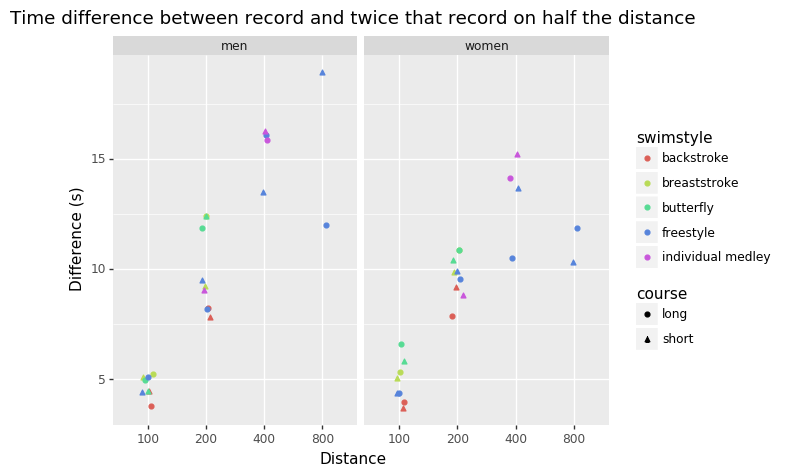

In [30]:
q = (view.category != "mixed") & ~view.swimstyle.str.contains("relay")

fig = pn.ggplot(view[q].dropna()) + \
    pn.geom_jitter(
        pn.aes(x = "factor(distance)", y = "difference", color = "swimstyle", shape = "course"),
        width = .1, height = 0) + \
    pn.facet_wrap(facets = "category") + \
    pn.labs(
        x = "Distance", 
        y = "Difference (s)",
        title = "Time difference between record and twice that record on half the distance")
    
fig.draw();

Well, the start doesn't save more than a couple of seconds, but it's hard to say more. These difference are mainly fatigue of the swimmer. 

I do see some other interesting patterns. It seems the record for freestyle 400m, for men, on a long course, is not  as sharp as it could be. Also the male records on 100m butterfly are quite fast compared to the 200m records. 

### 8. Conclusion

The data is cleaned. We have an idea of how long a turn takes, or rather, how much time it saves. I haven't come up with an easy method to isolate the starting times. The clean data can be found on GitHub if you want to give this a try, or perhaps you want to have a look at one of these other open questions:

* Why are the records posted mainly in June, July, November and December?
* How does the time saved with a turn differ across swimmers, for example world records vs. professionals vs. amateurs?
* How can we make a model that predicts the next record to be set?